#### Imports ####

In [301]:
import os
import torch
import numpy as np
import normflows as nf
import hydra
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from scipy.stats import kendalltau

from flows import RealNVP, NeuralSplineFlow
from prefflow import PrefFlow
from plotter import Plotter
from target import set_up_problem
from misc import convert_to_ranking
from pcbo_dataset import PCBO_SyntheticDataset
from torch.utils.data import DataLoader
from dag_visual import plot_dag
from parent_posterior import ParentPosterior

#### Load config file to set-up experiment and algorithm details ####

In [302]:
with hydra.initialize(version_base=None, config_path="conf"):
   os.chdir(os.getcwd())
   output_folder = os.path.join(os.getcwd(), 'temporary_outputs')
   cfg = hydra.compose(config_name="config.yaml",overrides=["+db=mysql"])
if not cfg.plot.showduringtraining: # Show plots?
    matplotlib.use('Agg') 

#### Device and Precision ####

In [303]:
torch.set_default_dtype(torch.float64 if cfg.device.precision_double else torch.float32)
device = torch.device(cfg.device.device)

#### Random seeds ####

In [304]:
import random
torch.manual_seed(cfg.exp.seed)
np.random.seed(cfg.exp.seed)
random.seed(cfg.exp.seed)

  #### Target belief density ####

In [305]:
# target_name = cfg.exp.target
# D = cfg.exp.d
# target, bounds, uniform, D, normalize = set_up_problem(target_name,D)

In [306]:
D = cfg.exp.d  # Dimension of the input space
ranking = cfg.data.k > 2  # Is it a ranking problem?
dataset = PCBO_SyntheticDataset(n_queries=cfg.data.n, k=cfg.data.k, d=D)
dataloader = DataLoader(dataset, batch_size=cfg.params.batch_size, shuffle=True)

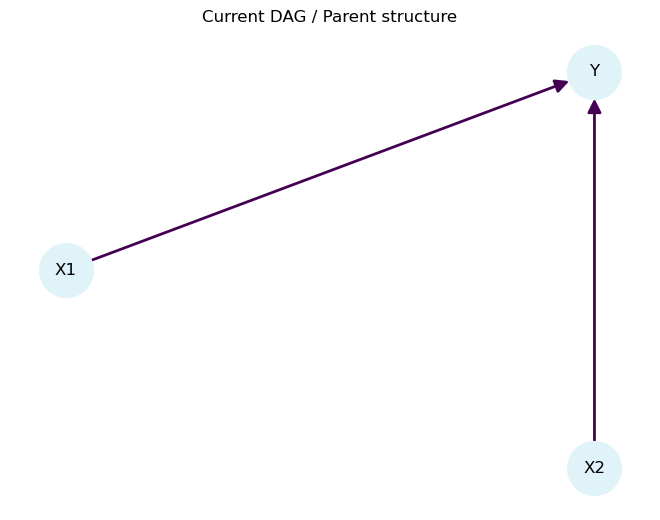

In [307]:
plot_dag(dataset.adj.numpy(), dataset.node_names)

#### Base distribution and Flow architecture ####

In [308]:
q0 = nf.distributions.DiagGaussian(D, trainable=False)
nflows = cfg.params.nflows
if cfg.params.flow == "realnvp":
    nfm = RealNVP(nflows,D,q0,device,cfg.device.precision_double)
if cfg.params.flow == "neuralsplineflow":
    nfm = NeuralSplineFlow(nflows,D,q0,device,cfg.device.precision_double)

#### Data generation 1/2 ####

In [309]:
# target_sample = target.sample(10000)
# target_mean = target_sample.mean(dim=0).double()
# target_std = target_sample.std(dim=0).double()

# def sample_alternatives(n,k=2,distribution="uniform"):
#         if distribution=="uniform":
#             return uniform.sample(torch.tensor([k*n])).to(device)
#         elif distribution=="target":
#             return target.sample(k*n).to(device)
#         elif distribution=="mixture_uniform_gaussian":
#             target_gaussian = torch.distributions.MultivariateNormal(target_mean, target_std*torch.eye(D))
#             howoftentarget = cfg.exp.mixture_success_prob
#             samples = []  
#             for _ in range(k):
#                 if np.random.sample() <= howoftentarget:
#                     x = target_gaussian.sample((n,))
#                 else:
#                     x = uniform.sample(torch.tensor([n])).to(device)
#                 samples.append(x)
#             return torch.cat(samples, dim=0)
        
# def expert_feedback_pairwise(comp,s=None):
#     noise = (0,0) if (s is None) else torch.distributions.Exponential(s).sample((2,)).to(device)
#     logprobs = target.log_prob(comp).to(device)
#     return torch.ge(logprobs[0] + noise[0],logprobs[1] + noise[1]).long().view(1).to(device)

# def expert_feedback_ranking(alternatives,s=None):
#     k = alternatives.shape[0]
#     noise = torch.distributions.Exponential(s).sample((k,)).to(device)
#     logprobs = target.log_prob(alternatives).to(device) + noise
#     _, ranking_inds = torch.sort(logprobs, descending=True)
#     return ranking_inds.view(k).to(device)

# def generate_dataset(N,s=None,distribution="uniform"):
#     X = sample_alternatives(1,2,distribution)
#     Y = expert_feedback_pairwise(X,s)
#     X = X.unsqueeze(2) #add new dimension, which indicates sample index
#     if N > 1:
#         for i in range(0,N-1):
#             comp = sample_alternatives(1,2,distribution)
#             X = torch.cat((X,comp.unsqueeze(2)),2)
#             Y = torch.cat((Y,expert_feedback_pairwise(comp,s)),0)
#     return X,Y #X.shape = (2,D,N) = (comp,space dimensions, number of comps)

# def generate_dataset_ranking(N,k,s=None,distribution="uniform"):
#     X = sample_alternatives(1,k,distribution)
#     Y = expert_feedback_ranking(X,s).view(1,k)
#     X = X.unsqueeze(2) #add new dimension, which indicates sample index
#     if N > 1:
#         for i in range(0,N-1):
#             alternatives = sample_alternatives(1,k,distribution)
#             X = torch.cat((X,alternatives.unsqueeze(2)),2)
#             Y = torch.cat((Y,expert_feedback_ranking(alternatives,s).view(1,k)),0)
#     Xdata = convert_to_ranking(X.numpy(),Y.numpy())
#     #return X,Y #X.shape = (k,D,N) = (alternatives,space dimensions, number of rankings)
#     return torch.from_numpy(Xdata).view(k,-1,N) 

#### Data generation 2/2 ####

In [310]:
# n = cfg.data.n
# true_s = cfg.exp.true_s
# ranking = True if cfg.data.k > 2 else False
# if ranking:
#     k = cfg.data.k
#     dataset = generate_dataset_ranking(N=n,k=k,s=true_s,distribution=cfg.exp.lambda_dist)
# else:
#     dataset = generate_dataset(N=n,s=true_s,distribution=cfg.exp.lambda_dist)
        
# def minibatch(dataset,batch_size,ranking):
#     indices = torch.randperm(n)[:batch_size]
#     batch = (dataset[0][:,:,indices],dataset[1][indices]) if not ranking else dataset[:,:,indices]
#     return batch

In [311]:
# def minibatch(dataloader):
#     x_choices, winner_indices = next(iter(dataloader))  # shapes: (B, k, d), (B,)
#     x_choices = x_choices.permute(1,2,0)                # (k, d, B)
#     return x_choices, winner_indices

def minibatch(dataloader, ranking):
    x_choices, winner_indices = next(iter(dataloader))  # (B, k, d), (B,)
    x_choices = x_choices.permute(1,2,0)                # (k, d, B)

    if ranking:
        # pass only the tensor of alternatives
        return x_choices                # shape (k, d, B)
    else:
        # pairwise expects a tuple (X_raw, Y)
        return x_choices, winner_indices

  #### Initialize preferential flow ####

In [312]:
prefflow = PrefFlow(nfm,D=D,s=cfg.modelparams.s,ranking=ranking,device=device,precision_double=cfg.device.precision_double)

#### Initialize optimizer ####

In [313]:
loss_hist = np.array([])
batch_size = cfg.params.batch_size
optimizer = getattr(torch.optim, cfg.params.optimizer.capitalize())
optimizer_prefflow = optimizer([{'params':prefflow.parameters()}],lr=cfg.params.lr, weight_decay=cfg.params.weight_decay)

#### Initialize plotter ####

In [314]:
# plotter = Plotter(D,bounds)

### SGD FS-MAP ###

In [315]:
for it in tqdm(range(cfg.params.max_iter),disable=not cfg.plot.progressbar_show):
    
    # Sample minibatch
    batch = minibatch(dataloader, ranking)

    # Update flow parameters
    prefflow.train()
    optimizer_prefflow.zero_grad()
    loss = -prefflow.logposterior(batch, cfg.modelparams.weightprior)
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer_prefflow.step()
    loss_hist = np.append(loss_hist, loss.to('cpu').detach().numpy())

    # Plot learned density
    if (it + 1) % cfg.plot.show_iter == 0:
        print("loss: " + str(loss.to('cpu').detach().numpy()))
        # if cfg.plot.showdatapoints:
        #     showdata = minibatch(dataset,batch_size=n,ranking=ranking)
        #     probmassinarea = plotter.plot_moon(target,prefflow,data=showdata,cfg=cfg)
        # else:
        #     probmassinarea = plotter.plot_moon(target,prefflow,data=None,cfg=cfg)
        # plt.show()

 13%|█▎        | 255/2000 [00:07<00:53, 32.60it/s]

loss: 29.908077


 25%|██▌       | 507/2000 [00:15<00:40, 37.20it/s]

loss: 29.338558


 38%|███▊      | 755/2000 [00:22<00:38, 32.25it/s]

loss: 31.685585


 50%|█████     | 1006/2000 [00:29<00:28, 34.71it/s]

loss: 33.081337


 63%|██████▎   | 1254/2000 [00:36<00:20, 36.84it/s]

loss: 27.19074


 75%|███████▌  | 1506/2000 [00:44<00:13, 36.82it/s]

loss: 30.45718


 88%|████████▊ | 1754/2000 [00:50<00:06, 36.34it/s]

loss: 31.897533


100%|██████████| 2000/2000 [00:58<00:00, 34.36it/s]

loss: 29.076855


#### Plot loss trajectory ####

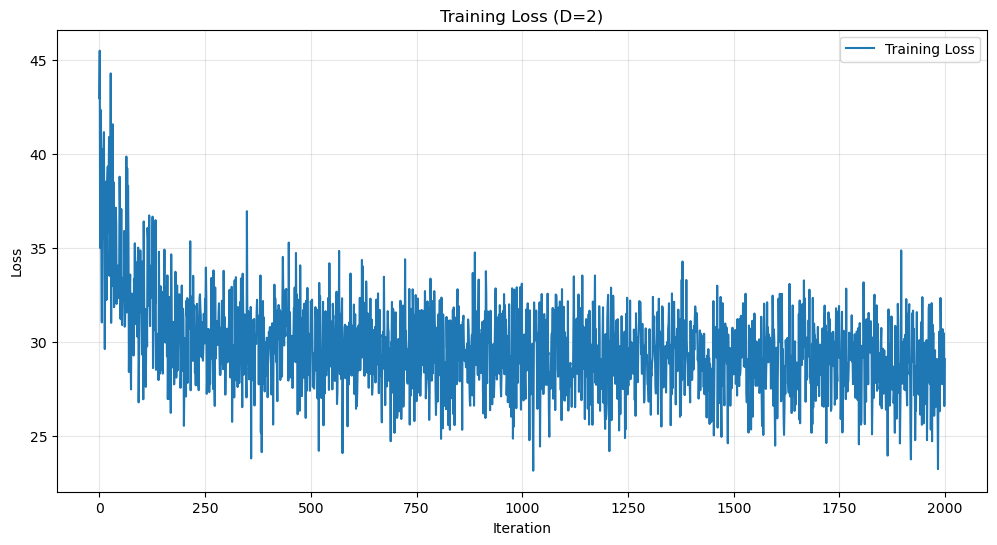

In [316]:
# -------- 1. Plot Learning Curve --------
plt.figure(figsize=(12, 6))
plt.plot(loss_hist, label='Training Loss')
plt.title(f"Training Loss (D={D})")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

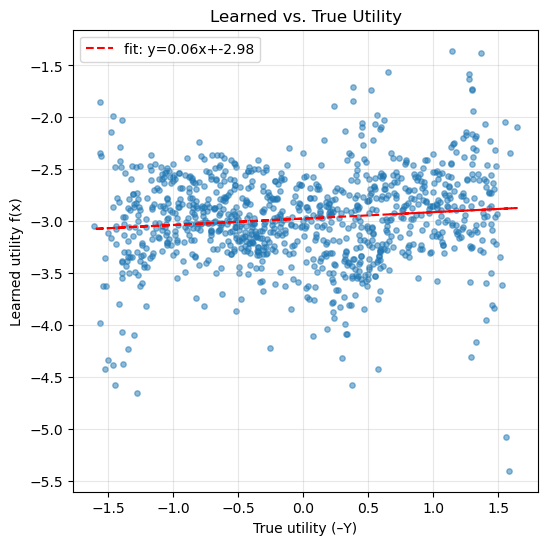

In [317]:
# ---- after training ----
import matplotlib.pyplot as plt

# 1. Sample a bunch of random interventions
N_vis = 1000
# domain = [−2,2] in each dimension (same as PCBO_SyntheticDataset)
X_vis = (torch.rand(N_vis, D) * (dataset.domain[1] - dataset.domain[0])
         + dataset.domain[0]).to(device)

# 2. Compute true utility and learned utility
with torch.no_grad():
    Y_vis = dataset.scm(X_vis)
    logf_vis, _ = prefflow.f(X_vis)
    u_true = (-Y_vis).cpu().numpy()
    u_learn = logf_vis.cpu().numpy()

# 3. Scatter
plt.figure(figsize=(6,6))
plt.scatter(u_true, u_learn, alpha=0.5, s=15)
m, b = np.polyfit(u_true, u_learn, 1)
plt.plot(u_true, m*u_true+b, 'r--', label=f'fit: y={m:.2f}x+{b:.2f}')
plt.xlabel('True utility (–Y)')
plt.ylabel('Learned utility f(x)')
plt.title('Learned vs. True Utility')
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

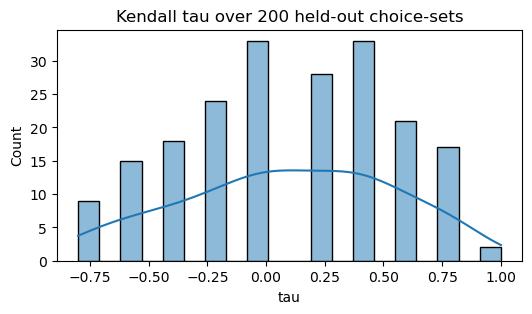

Mean tau: 0.09399999999999999


In [318]:
import seaborn as sns
from scipy.stats import kendalltau

def ranking_tau(prefflow, dataset, n_trials=200):
    taus = []
    for _ in range(n_trials):
        # sample one fresh query
        Xk, _, Yk = dataset._generate_one_query()  # now returns (k,d), idx, (k,)
        
        # true utility = –Yk
        u_true = (-Yk).cpu().numpy()
        
        # learned utility f(x)
        with torch.no_grad():
            logf, _ = prefflow.f(Xk.to(prefflow.device))  # shape (k,)
            u_learn = logf.cpu().numpy()
        
        tau, _ = kendalltau(u_true, u_learn)
        taus.append(tau)
    return np.array(taus)

taus = ranking_tau(prefflow, dataset, n_trials=200)
plt.figure(figsize=(6,3))
sns.histplot(taus, kde=True, bins=20)
plt.title(f'Kendall tau over {len(taus)} held-out choice-sets')
plt.xlabel('tau'); plt.ylabel('Count')
plt.show()
print('Mean tau:', taus.mean())

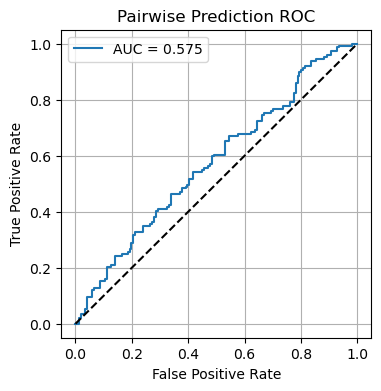

In [319]:
from sklearn.metrics import roc_curve, auc

# Build a test set of pairwise comps
probs, labels = [], []
for _ in range(300):
    # sample 2 interventions
    X2 = (torch.rand(2, D)*(dataset.domain[1]-dataset.domain[0]) + dataset.domain[0]).to(device)
    Y = dataset.scm(X2).cpu().numpy()
    true_label = 1 if Y[0]<Y[1] else 0  # “1” means index 0 wins
    # model’s probability index 0 wins:
    with torch.no_grad():
        logf, _ = prefflow.f(X2)
        p0 = torch.sigmoid((logf[0]-logf[1])/prefflow.s).cpu().item()
    probs.append(p0)
    labels.append(true_label)

fpr, tpr, _ = roc_curve(labels, probs)
roc_auc   = auc(fpr, tpr)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Pairwise Prediction ROC')
plt.legend(); plt.grid(True)
plt.show()

In [320]:
# # -------- 2. Overlay PCA Projections: True vs. Learned --------
# # Sample from both true and learned distributions
# n_vis = 1000
# true_samples = target.sample(n_vis).detach().cpu().numpy()
# pnf_samples = prefflow.sample(n_vis)[0].detach().cpu().numpy()

# # Fit PCA on the combined data
# pca = PCA(n_components=2).fit(np.vstack([true_samples, pnf_samples]))
# true_proj = pca.transform(true_samples)
# pnf_proj = pca.transform(pnf_samples)

# plt.figure(figsize=(7, 7))
# plt.scatter(true_proj[:, 0], true_proj[:, 1], alpha=0.5, label="True", s=10)
# plt.scatter(pnf_proj[:, 0], pnf_proj[:, 1], alpha=0.5, label="PNF", s=10)
# plt.title(f"PCA Projection: True vs. PNF Samples (D={D}, n={n})")
# plt.xlabel("PC1"); plt.ylabel("PC2")
# plt.legend()
# plt.show()

In [321]:
# # -------- 3. KL Divergence Estimate (Monte Carlo) --------
# # KL(PNF || True): E_PNF [log q(x) - log p(x)]
# pnf_samples_torch = torch.from_numpy(pnf_samples).to(device)
# with torch.no_grad():
#     logq = prefflow.log_prob(pnf_samples_torch).detach().cpu().numpy()
#     logp = target.log_prob(pnf_samples_torch).detach().cpu().numpy()
# kl_estimate = np.mean(logq - logp)
# print(f"Estimated KL(PNF || True) on PNF samples: {kl_estimate:.4f}")

In [322]:
# # -------- 4. Log-Likelihood of Held-Out Preferences --------
# # Generate held-out preference queries
# def heldout_log_likelihood(target, prefflow, n_queries=100, k=2):
#     ll_list = []
#     for _ in range(n_queries):
#         # Generate two alternatives from the uniform or true distribution
#         x = target.sample(k).to(device)
#         # True label (by true target)
#         logprobs = target.log_prob(x)
#         y_true = int(logprobs[0] > logprobs[1])
#         # Model predicted probabilities
#         logf, _ = prefflow.f(x)
#         prob_01 = torch.sigmoid(logf[0] - logf[1]).cpu().item()
#         ll = np.log(prob_01 if y_true else 1 - prob_01 + 1e-10)
#         ll_list.append(ll)
#     return np.mean(ll_list)

# heldout_ll = heldout_log_likelihood(target, prefflow, n_queries=100)
# print(f"Mean log-likelihood on 100 held-out preferences: {heldout_ll:.4f}")

In [323]:
# # -------- 5. Ranking Consistency (Kendall tau) --------
# def ranking_consistency(target, prefflow, n_queries=50, k=5):
#     tau_list = []
#     for _ in range(n_queries):
#         x = target.sample(k).to(device)
#         u_true = target.log_prob(x).detach().cpu().numpy()
#         logf, _ = prefflow.f(x)
#         u_pred = logf.detach().cpu().numpy()
#         tau, _ = kendalltau(u_true, u_pred)
#         tau_list.append(tau)
#     return np.nanmean(tau_list)

# mean_tau = ranking_consistency(target, prefflow, n_queries=50, k=min(5, D))
# print(f"Mean Kendall tau (ranking consistency, k=5): {mean_tau:.4f}")

### Update Parent Posterior

In [324]:
ppost = ParentPosterior(d=2, sigma_eps=0.1, sigma_theta=1.0, prior_sparsity=0.3)
for x,y in some_points_from_dataset:
    ppost.add_datapoint(x.unsqueeze(0), y.item())
ppost.update_posterior()
print("Edge probs:", ppost.edge_posterior())

NameError: name 'some_points_from_dataset' is not defined

### Visualise DAG with posterior edge weights

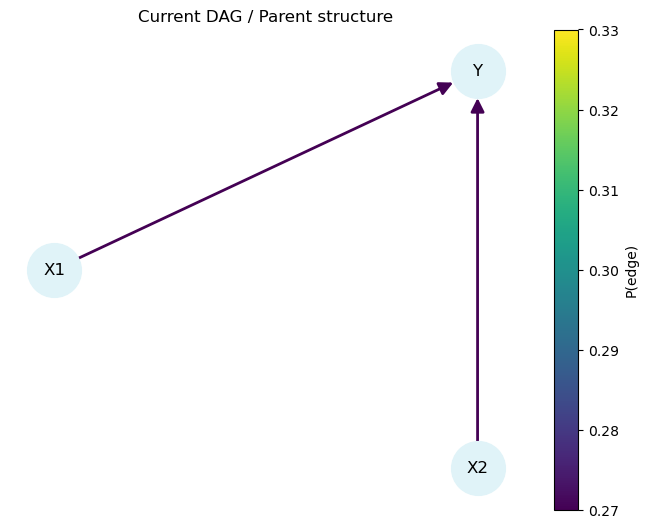

In [ ]:
adj = np.array([[0,0,1],
                [0,0,1],
                [0,0,0]])
edge_probs = np.array([[0,0,ppost.edge_posterior()[0]],
                       [0,0,ppost.edge_posterior()[1]],
                       [0,0,0]])
plot_dag(adj, names=["X1","X2","Y"], edge_probs=edge_probs)